1. Build a Neural Machine Translation model.
2. Evaluate your model using BLEU score

In [ ]:
pip install Unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 15.4 MB/s eta 0:00:00


In [ ]:
# import all dependentcies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import string
import unicodedata
from unidecode import unidecode
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras import optimizers

First we need to download dataset from provided link
Dataset: http://www.manythings.org/anki/fra-eng.zip

In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2023-07-08 08:31:40--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7420323 (7.1M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.08M  4.21MB/s    in 1.7s    

2023-07-08 08:31:42 (4.21 MB/s) - ‘fra-eng.zip’ saved [7420323/7420323]



In [ ]:
# check left hand side file fra-eng.zip, zip file has been downloaded
# now, we need to unzip this file
import zipfile
# copy dataset file path
zip_ref = zipfile.ZipFile("/content/fra-eng.zip", "r")
zip_ref.extractall('/content')
zip_ref.close()

##### after unzip, we have 2 text file, one is fra.txt and other is _about.txt,

In [ ]:
# open fra.txt file
text = open("/content/fra.txt", "r", encoding = "utf-8").read()

In [ ]:
#split a text into sentences
def to_sentences(text):
  # split text data into sentences
  sentences = text.strip().split('\n')
  # now, I am taking 75000 lines
  sen = [i.split('\t') for i in sentences[:100000]]
  return np.array(sen)

In [ ]:
# call to_sentences function
eng_fra = to_sentences(text)
eng_fra.shape

(100000, 3)

In [ ]:
eng_fra[:10]

array([['Go.', 'Va !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go.', 'Marche.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go.', 'En route !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)'],
       ['Go.', 'Bouge !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ['Hi.', 'Salut !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)'],
       ['Hi.', 'Salut.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)'],
       ['Run!', 'Cours\u202f!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)'],
       ['Run!', 'Courez\u202f!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)'],
       ['Run!', 'Prenez vos jambes

In [ ]:
# in eng_fra text data, there are 3 columns, 1-> eng text, 2-> french text and 3-> discribtion
# we need to only first 2 columns
eng_fra = eng_fra[:, :2]
random.shuffle(eng_fra)
# split data into english_text and french_text
eng_text = eng_fra[:, 0]
fra_text = eng_fra[:, 1]

In [ ]:
eng_text.shape, fra_text.shape # sentences length are not same

((100000,), (100000,))

## **Clean Data**
#### Remove the non printable charaters, if any
#### Remove punctuations and non-alphabetic charaters
#### Convert to lowercase

In [ ]:
# demo,
word = 'Prenez vos jambes à vos cous !'
decode_word = unidecode(word)
print(word, '--->', decode_word)

Prenez vos jambes à vos cous ! ---> Prenez vos jambes a vos cous !


In [ ]:
def clean_data(sentences):
  data = []
  for word in sentences:
    # decode the word
    word = unidecode(word)
    # remove special characters and numbers
    word = re.sub('[^a-zA-z]', ' ', word)
    # remove extra spaces
    word = word.strip()
    # lower case
    word = word.lower()
    word = ''.join(w for w in unicodedata.normalize('NFKD', word))
    data.append(word)
  return np.array(data)

In [ ]:
# clean french text and convert into list of word
fra_input = clean_data(fra_text)
# clean english text and convert into list of word
eng_target = clean_data(eng_text)

In [ ]:
fra_input[:10]

array(['va', 'marche', 'va', 'bouge', 'en route', 'bouge', 'en route',
       'salut', 'bouge', 'en route'], dtype='<U59')

In [ ]:
eng_target[:10]

array(['go', 'go', 'go', 'go', 'go', 'go', 'go', 'hi', 'go', 'go'],
      dtype='<U26')

### **Split Data into train and test**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(fra_input, eng_target, test_size = 0.20, random_state = 42)

In [ ]:
x_train.shape, y_train.shape

((80000,), (80000,))

In [ ]:
x_test.shape, y_test.shape

((20000,), (20000,))

In [ ]:
x_train[:10]

array(['t es etudiant', 'personne n a vu quoi que ce soit',
       'nous avons choisi celui ci', 'je ne peux pas bouger',
       'je n ai pas d intimite', 'c est chouette', 'ne le gaspille pas',
       'je t ai vu', 'est ce que tu as une bicyclette', 'tu es bonne'],
      dtype='<U59')

In [ ]:
y_train[:10]

array(['are you a student', 'no one saw anything', 'we chose this one',
       'i can t move', 'i have no privacy', 'this is nice',
       'don t waste it', 'i saw you', 'do you have a bicycle',
       'you re good'], dtype='<U26')

## **Apply Tokenization**
#### convert words with their correcponding specific integers

In [ ]:
def tokenization(text_data):
  # create tokenizer
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text_data)
  integer_sequence = tokenizer.texts_to_sequences(text_data)
  vocab = tokenizer.word_index
  vocab_size = len(vocab) + 1
  max_seq_len = max(len(seq) for seq in integer_sequence)

  return tokenizer, vocab, vocab_size, max_seq_len

In [ ]:
# get tokenizer, vocabulary , vocabulary size and max_sequence_length
fra_tokenizer ,fra_vocab, fra_vocab_size, max_fra_seq_len = tokenization(fra_input)
print('french vocabulary size :', fra_vocab_size)
print('french max sequence length : ', max_fra_seq_len)

french vocabulary size : 10456
french max sequence length :  13


In [ ]:
fra_vocab

{'je': 1,
 'est': 2,
 'a': 3,
 'tom': 4,
 'vous': 5,
 'pas': 6,
 'j': 7,
 'il': 8,
 'de': 9,
 'le': 10,
 'ai': 11,
 'nous': 12,
 'ne': 13,
 'tu': 14,
 'suis': 15,
 'c': 16,
 'la': 17,
 'un': 18,
 'l': 19,
 'en': 20,
 'ce': 21,
 'n': 22,
 'que': 23,
 'ca': 24,
 'me': 25,
 'une': 26,
 'moi': 27,
 'etes': 28,
 'les': 29,
 'd': 30,
 'es': 31,
 't': 32,
 'y': 33,
 's': 34,
 'm': 35,
 'elle': 36,
 'fait': 37,
 'etait': 38,
 'ils': 39,
 'qui': 40,
 'sont': 41,
 'sommes': 42,
 'tout': 43,
 'as': 44,
 'te': 45,
 'toi': 46,
 'mon': 47,
 'faire': 48,
 'qu': 49,
 'aime': 50,
 'des': 51,
 'elles': 52,
 'du': 53,
 'peux': 54,
 'avez': 55,
 'bien': 56,
 'ici': 57,
 'tres': 58,
 'ete': 59,
 'cela': 60,
 'veux': 61,
 'va': 62,
 'besoin': 63,
 'on': 64,
 'avons': 65,
 'se': 66,
 'votre': 67,
 'pour': 68,
 'air': 69,
 'ont': 70,
 'aller': 71,
 'fais': 72,
 'ou': 73,
 'faut': 74,
 'personne': 75,
 'etre': 76,
 'comment': 77,
 'au': 78,
 'etais': 79,
 'plus': 80,
 'ton': 81,
 'pourquoi': 82,
 'ma': 83,
 's

In [ ]:
# get tokenizer, vocabulary , vocabulary size and max_sequence_length
eng_tokenizer ,eng_vocab, eng_vocab_size, max_eng_seq_len = tokenization(eng_target)
print('french vocabulary size :', fra_vocab_size)
print('french max sequence length : ', max_eng_seq_len)

french vocabulary size : 10456
french max sequence length :  8


In [ ]:
eng_vocab

{'i': 1,
 'you': 2,
 'it': 3,
 'tom': 4,
 'a': 5,
 'is': 6,
 's': 7,
 't': 8,
 'we': 9,
 'm': 10,
 're': 11,
 'the': 12,
 'that': 13,
 'to': 14,
 'he': 15,
 'me': 16,
 'this': 17,
 'was': 18,
 'do': 19,
 'are': 20,
 'can': 21,
 'they': 22,
 'don': 23,
 'have': 24,
 'go': 25,
 'be': 26,
 'my': 27,
 'your': 28,
 'not': 29,
 'what': 30,
 'll': 31,
 'did': 32,
 'like': 33,
 'get': 34,
 'in': 35,
 'here': 36,
 'all': 37,
 'she': 38,
 'no': 39,
 'let': 40,
 'up': 41,
 'how': 42,
 'on': 43,
 'want': 44,
 'of': 45,
 'very': 46,
 'need': 47,
 'know': 48,
 'out': 49,
 'come': 50,
 'one': 51,
 'for': 52,
 'who': 53,
 'him': 54,
 've': 55,
 'got': 56,
 'there': 57,
 'help': 58,
 'love': 59,
 'take': 60,
 'good': 61,
 'please': 62,
 'so': 63,
 'just': 64,
 'look': 65,
 'at': 66,
 'now': 67,
 'were': 68,
 'see': 69,
 'us': 70,
 'stop': 71,
 'too': 72,
 'will': 73,
 'why': 74,
 'has': 75,
 'am': 76,
 'where': 77,
 'had': 78,
 'home': 79,
 'back': 80,
 'must': 81,
 'won': 82,
 'with': 83,
 'keep': 84,

convert Train and test text data into integer sequence, and apply post padding

In [ ]:
def integer_seq_with_padding(tokenizer, text, max_seq_len):
  # convert words into their correcponding integer
  integer_sequence = tokenizer.texts_to_sequences(text)
  # apply padding, adding zeros to same max_seq_length
  sequence_padded = pad_sequences(integer_sequence, maxlen = max_seq_len, padding = 'post')
  return sequence_padded

In [ ]:
x_train_padded = integer_seq_with_padding(fra_tokenizer ,x_train, max_fra_seq_len)
y_train_padded = integer_seq_with_padding(eng_tokenizer ,y_train, max_eng_seq_len)

In [ ]:
x_train_padded.shape, y_train_padded.shape

((80000, 13), (80000, 8))

In [ ]:
x_test_padded = integer_seq_with_padding(fra_tokenizer ,x_test, max_fra_seq_len)
y_test_padded = integer_seq_with_padding(eng_tokenizer ,y_test, max_eng_seq_len)

In [ ]:
x_test_padded.shape, y_test_padded.shape

((20000, 13), (20000, 8))

## **Encoder Decoder Sequential Model**

In [ ]:
def create_model(input_vocab_size, output_vocab_size, input_timesteps, output_timesteps, units):
    model = Sequential()
    model.add(Embedding(input_vocab_size, units, input_length = input_timesteps, mask_zero=True))
    model.add(LSTM(units, dropout = 0.3))
    model.add(RepeatVector(output_timesteps))
    model.add(LSTM(units, return_sequences=True, dropout = 0.3))
    model.add(TimeDistributed(Dense(output_vocab_size, activation='softmax')))
    return model

In [ ]:
model = create_model(fra_vocab_size, eng_vocab_size, max_fra_seq_len, max_eng_seq_len, 1024)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 1024)          10706944  
                                                                 
 lstm (LSTM)                 (None, 1024)              8392704   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 1024)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 1024)           8392704   
                                                                 
 time_distributed (TimeDistr  (None, 8, 6331)          6489275   
 ibuted)                                                         
                                                                 
Total params: 33,981,627
Trainable params: 33,981,627
No

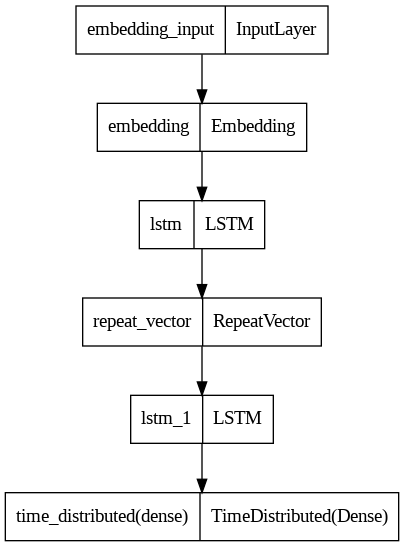

In [ ]:
plot_model(model)

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy',patience = 5, min_delta = 0.01)

In [ ]:
history = model.fit(x_train_padded, y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1],1),
          epochs = 30,
          batch_size = 1024,
          validation_data = (x_test_padded, y_test_padded.reshape(y_test_padded.shape[0], y_test_padded.shape[1],1)),
          verbose = 1, callbacks = [es])

Epoch 1/30
79/79 [==============================] - 37s 343ms/step - loss: 3.1558 - accuracy: 0.5565 - val_loss: 2.6109 - val_accuracy: 0.5878
Epoch 2/30
79/79 [==============================] - 27s 343ms/step - loss: 2.4399 - accuracy: 0.6106 - val_loss: 2.2761 - val_accuracy: 0.6320
Epoch 3/30
79/79 [==============================] - 29s 363ms/step - loss: 2.0813 - accuracy: 0.6561 - val_loss: 1.9868 - val_accuracy: 0.6711
Epoch 4/30
79/79 [==============================] - 33s 419ms/step - loss: 1.8128 - accuracy: 0.6869 - val_loss: 1.8201 - val_accuracy: 0.6879
Epoch 5/30
79/79 [==============================] - 30s 378ms/step - loss: 1.5924 - accuracy: 0.7103 - val_loss: 1.5826 - val_accuracy: 0.7137
Epoch 6/30
79/79 [==============================] - 30s 376ms/step - loss: 1.3954 - accuracy: 0.7329 - val_loss: 1.4253 - val_accuracy: 0.7331
Epoch 7/30
79/79 [==============================] - 30s 378ms/step - loss: 1.2204 - accuracy: 0.7566 - val_loss: 1.2812 - val_accuracy: 0.7526

Save Model

In [ ]:
model_name = 'NMT_model.h5'
model.save(model_name)

## plot model train and test accuracy and loss

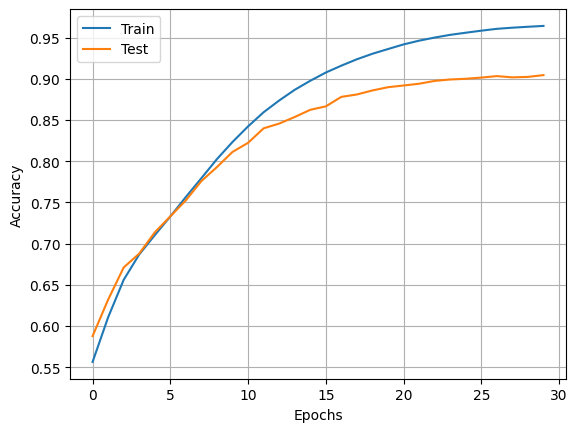

In [ ]:
train_data_acc = history.history['accuracy']
test_data_acc = history.history['val_accuracy']
plt.plot(train_data_acc)
plt.plot(test_data_acc)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

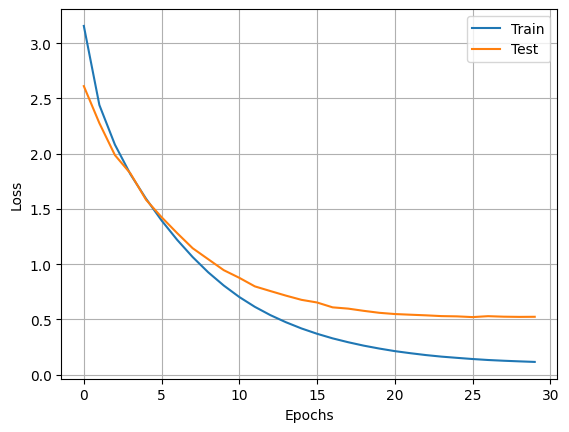

In [ ]:
train_data_loss = history.history['loss']
test_data_loss = history.history['val_loss']
plt.plot(train_data_loss)
plt.plot(test_data_loss)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

## Predict Test data

In [ ]:
# check text data shape
x_test_padded.shape

(20000, 13)

In [ ]:
#NMT_model = load_model('/content/NMT_model.h5')

In [ ]:
# predict test data
predicted = model.predict(x_test_padded)

625/625 [==============================] - 6s 8ms/step


In [ ]:
# predicted shape
predicted.shape

(20000, 8, 6331)

In [ ]:
# now, we need to decode predicted data into english integer sequence
preds = []
for seq in predicted:
  temp = []
  for j in seq:
    temp.append(np.argmax(j))
  # remove padding
  temp = [w for w in temp if w != 0]
  preds.append(temp)

In [ ]:
preds

[[74, 19, 2, 44, 5, 127],
 [3, 7, 5, 320, 3975],
 [4, 6, 1165],
 [20, 2, 149, 2, 11, 146],
 [20, 2, 550],
 [19, 2, 33, 90],
 [3, 7, 1045, 7],
 [9, 47, 574],
 [20, 2, 776],
 [4, 18, 186],
 [3, 7, 5, 290, 676],
 [15, 258, 1623],
 [13, 7, 741],
 [4, 6, 902],
 [968, 17],
 [639, 47, 2923],
 [147],
 [9, 91],
 [3, 7, 1190, 5, 3328],
 [1, 10, 937],
 [3, 162, 8, 13, 136],
 [6, 4, 146],
 [9, 78, 420],
 [4, 125],
 [288, 665],
 [90, 376, 6, 196],
 [1, 86, 8, 19, 13, 13],
 [21, 2, 137, 5, 1962],
 [20, 2, 24, 14, 16],
 [42, 505],
 [4, 185, 3],
 [1, 355, 102, 3],
 [13, 7, 2355],
 [407, 56, 4418],
 [1, 10, 41, 36],
 [32, 2, 33, 3],
 [6, 57, 302, 317, 140],
 [1, 10, 651],
 [15, 7, 186, 290, 1423, 1336],
 [4, 227, 245],
 [4, 6, 29, 2771],
 [86, 8, 2, 456, 12, 5006],
 [1, 82, 8, 183, 17],
 [4, 6, 5, 3103],
 [2, 11, 972],
 [13, 7, 36, 27, 7, 36],
 [38, 111, 16, 5, 645],
 [1, 10, 35, 39, 194],
 [2, 11, 505],
 [12, 127, 467, 12, 12],
 [9, 32, 3, 1232],
 [1, 111, 5, 717],
 [6, 3, 142],
 [77, 6, 12, 556],
 [1

In [ ]:
# convert predicted integer sequences into their corresponding word
predict_text = eng_tokenizer.sequences_to_texts(preds)

In [ ]:
predict_text

['why do you want a dog',
 'it s a bit flimsy',
 'tom is stalling',
 'are you sure you re ok',
 'are you honest',
 'do you like his',
 'it s half s',
 'we need somebody',
 'are you dressed',
 'tom was been',
 'it s a dead end',
 'he looked fresh',
 'that s clever',
 'tom is huge',
 'memorize this',
 'children need loving',
 'run',
 'we lost',
 'it s clearly a hoax',
 'i m discreet',
 'it wasn t that big',
 'is tom ok',
 'we had two',
 'tom went',
 'drive slowly',
 'his son is sick',
 'i didn t do that that',
 'can you make a salad',
 'are you have to me',
 'how rude',
 'tom likes it',
 'i myself saw it',
 'that s logical',
 'things got messy',
 'i m up here',
 'did you like it',
 'is there any beer left',
 'i m naked',
 'he s been dead ten years',
 'tom seems calm',
 'tom is not dummy',
 'didn t you understand the manual',
 'i won t forget this',
 'tom is a pianist',
 'you re powerful',
 'that s here my s here',
 'she made me a cake',
 'i m in no hurry',
 'you re rude',
 'the dog stopp

In [ ]:
y_test

array(['why do you want a dog', 'it s a bit flimsy', 'tom s stalling',
       ..., 'you ve seen enough', 'they found it', 'no place is perfect'],
      dtype='<U26')

In [ ]:
df = pd.DataFrame({'Text': y_test, 'Predicted':predict_text})

In [ ]:
df

,Text,Predicted
0,why do you want a dog,why do you want a dog
1,it s a bit flimsy,it s a bit flimsy
2,tom s stalling,tom is stalling
3,are you sure you re ok,are you sure you re ok
4,are you honest,are you honest
...,...,...
19995,i m so glad,i m so glad
19996,they re all bad,they re all bad
19997,you ve seen enough,you ve seen enough
19998,they found it,they found it


Use BLEU score for evaluating model using NLTK library

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
Sum = 0
for i in range(len(df)):
  reference = [df['Text'][i].split()]
  candidate = df['Predicted'][i].split()
  score = sentence_bleu(reference, candidate, weights = (1.0, 0, 0, 0))
  Sum += score

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
print("The average Bleu Score is {:.2f} %".format(Sum*100/len(df)))

The average Bleu Score is 82.90 %


In [ ]:
df_same = df[df['Text'] == df['Predicted']]
df_same

,Text,Predicted
0,why do you want a dog,why do you want a dog
1,it s a bit flimsy,it s a bit flimsy
3,are you sure you re ok,are you sure you re ok
4,are you honest,are you honest
7,we need somebody,we need somebody
...,...,...
19995,i m so glad,i m so glad
19996,they re all bad,they re all bad
19997,you ve seen enough,you ve seen enough
19998,they found it,they found it
